In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import lightkurve as lk
import triceratops.triceratops as tr
import triceratops.get_apertures as ga

/Users/jonathangomez/anaconda3/envs/tricer_dev/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/jonathangomez/.lightkurve/cache. Please move all the files in the legacy directory /Users/jonathangomez/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


# Running TRICERATOPS+ on a validated transiting planet

# TRICERATOPS+ Extension

## Overview

TRICERATOPS+ extends the functionality of the original TRICERATOPS package with enhanced capabilities for incorporating ground-based light curves into the analysis pipeline.

## Key Differences

The primary enhancement is in the `.calc_probs()` function, which now supports two additional arguments:

1. `external_lc_files`: A list of file paths (as strings) pointing to ground-based light curve data
2. `filt_lcs`: A list of strings specifying the photometric filters used for each light curve

## File Format Requirements

TRICERATOPS+ expects ground-based light curve files to be in `.txt` format with three columns:

| Column | Content | Notes |
|--------|---------|-------|
| 1 | Time from mid-transit (days) | No column header |
| 2 | Relative flux values | No column header |
| 3 | Relative flux error values | No column header |

## Supported Filters

The `filt_lcs` argument accepts the following photometric filter designations:

- `"g"` - SDSS g-band
- `"r"` - SDSS r-band
- `"i"` - SDSS i-band
- `"z"` - SDSS z-band
- `"J"` - NIR J-band
- `"H"` - NIR H-band
- `"K"` - NIR K-band

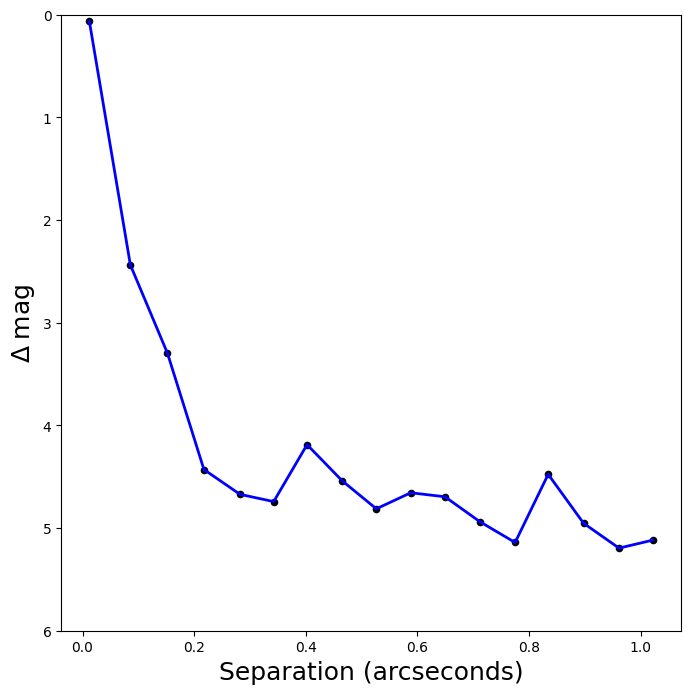

In [2]:
# First let's read and visualize the contrast curve for this target

contrastcurve_file = "./TOI4155_01_contrast_curve.csv"
cc = pd.read_csv(contrastcurve_file, header=None)
sep, dmag = cc[0].values, cc[1].values

fig = plt.figure(figsize=(8, 8))
plt.scatter(sep, dmag, s=20, c='black')
plt.plot(sep, dmag, lw=2, c='blue')
plt.ylim(6,0)
plt.ylabel(r"$\mathrm{\Delta \; mag}$", fontsize=18);
plt.xlabel("Separation (arcseconds)", fontsize=18);

In [3]:
# Specify the target's TIC ID
# Note: If you haven't previously run TRICERATOPS on this target, you likely 
# don't have a TRILEGAL.csv file yet. In that case, leave trilegal_fname as None.

ID = 467331291
trilegal_fname = "467331291_TRILEGAL.csv"

In [4]:
# let's list all 2-min light curves available for this target
lk.search_lightcurve(f'TIC {ID}', mission='TESS', author='SPOC')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 52,2022,SPOC,120,467331291,0.0
1,TESS Sector 53,2022,SPOC,120,467331291,0.0
2,TESS Sector 58,2022,SPOC,120,467331291,0.0
3,TESS Sector 59,2022,SPOC,120,467331291,0.0
4,TESS Sector 73,2023,SPOC,120,467331291,0.0
5,TESS Sector 77,2024,SPOC,120,467331291,0.0
6,TESS Sector 78,2024,SPOC,120,467331291,0.0
7,TESS Sector 79,2024,SPOC,120,467331291,0.0
8,TESS Sector 85,2024,SPOC,120,467331291,0.0


In [5]:
%%time
# Specify the TESS observation sectors for our target
# This allows TRICERATOPS to estimate contamination from nearby GAIA stars in the target aperture
# Using sectors 52, 73, and 79 for this tutorial
sectors = np.array([52, 73, 79])
target = tr.target(ID=ID, sectors=sectors, trilegal_fname = trilegal_fname)

CPU times: user 6.64 s, sys: 3.63 s, total: 10.3 s
Wall time: 55.6 s


In [6]:
# Acquire target apertures for each specified sector
# Note: This code only works for SPOC data (not compatible with QLP)
aps = []
for sector in sectors:
    ap = ga.get_aperture(ID, sector)
    aps.append(ap)

Sector 52


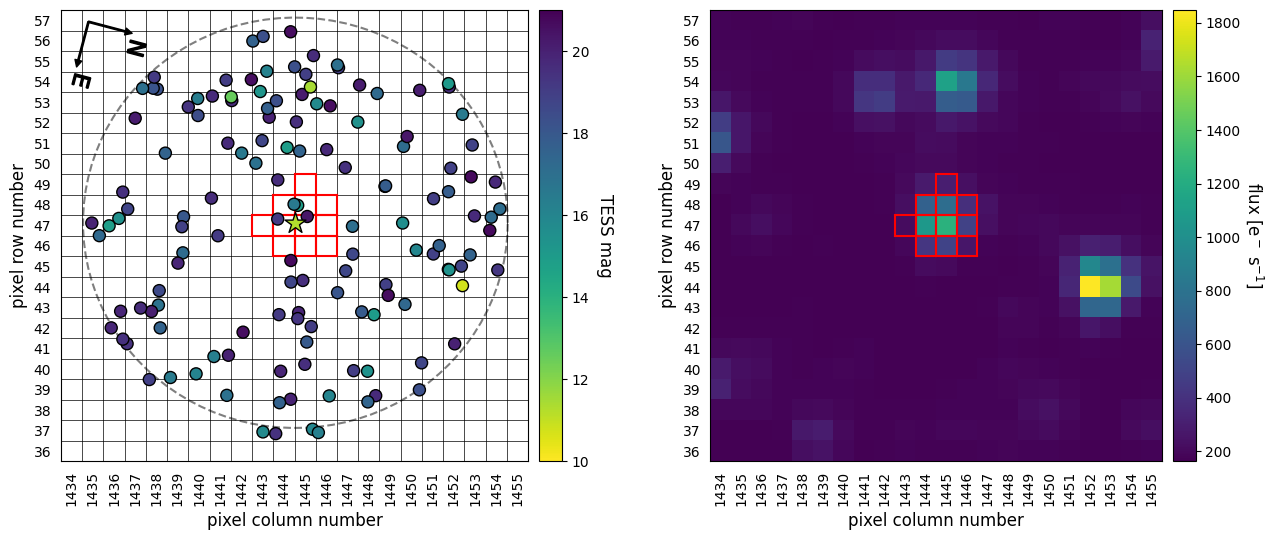

Sector 73


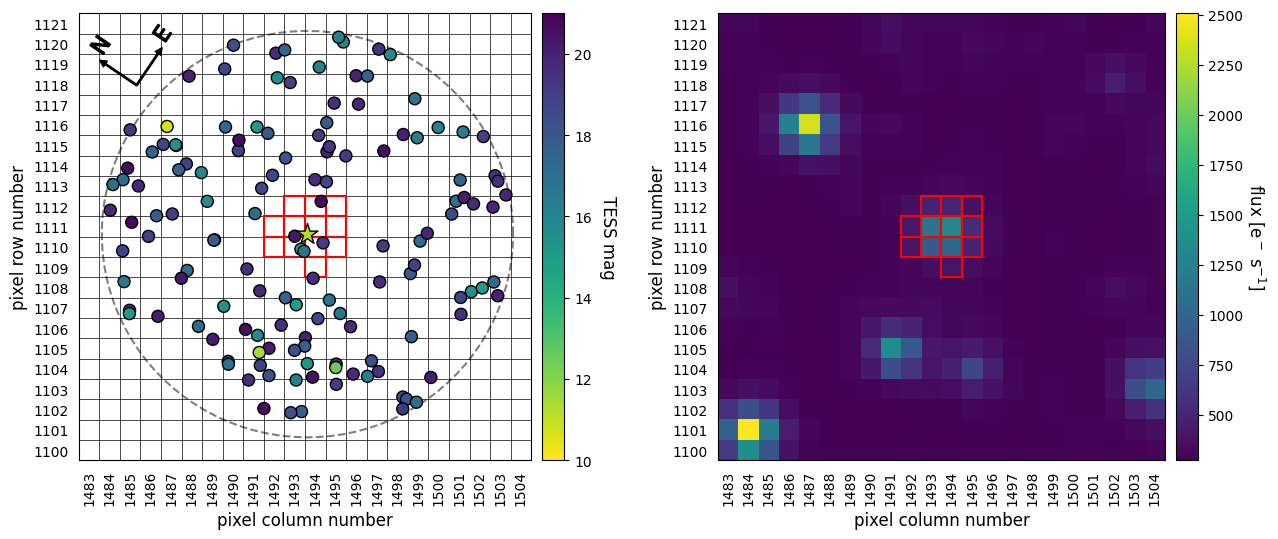

Sector 79


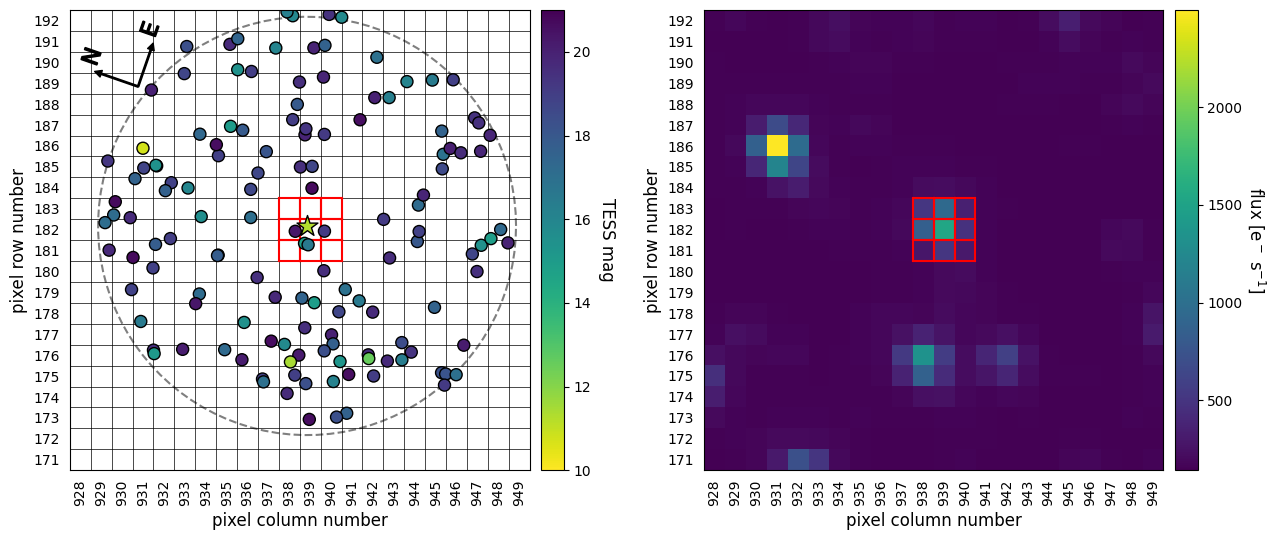

,ID,Bmag,Vmag,Tmag,Jmag,Hmag,Kmag,gmag,rmag,imag,zmag,ra,dec,mass,rad,Teff,d,plx,sep (arcsec),PA (E of N)
0,467331291,12.147,11.8500,11.2473,10.608,10.309,10.265,NaN,NaN,NaN,NaN,325.635589,77.734265,1.164000,0.952646,6142.0,240.737,4.125090,0.000,0.000
1,2023818168,NaN,21.2127,20.3391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.624177,77.736817,NaN,NaN,NaN,NaN,NaN,12.671,316.475
2,467331290,16.360,15.5960,14.8956,13.975,13.607,13.472,NaN,NaN,NaN,NaN,325.614120,77.733500,1.010000,1.789800,5678.0,1773.620,0.533932,16.649,260.488
3,2023818169,NaN,20.9308,19.1348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.637041,77.729445,NaN,NaN,NaN,1079.700,1.005090,17.387,176.336
4,467331288,16.261,17.5932,16.5486,14.455,15.123,13.890,NaN,NaN,NaN,NaN,325.613980,77.732479,0.920000,1.251480,5328.0,2358.980,0.377718,17.734,248.762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,467331498,19.224,17.4187,15.7877,14.560,13.823,13.633,NaN,NaN,NaN,NaN,325.895152,77.742137,0.649962,0.681093,3865.0,630.665,1.558830,200.466,81.746
134,2023818097,NaN,20.6573,19.4236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.893071,77.745547,NaN,NaN,NaN,1365.090,0.700979,200.982,78.215
135,2023818083,NaN,20.7557,18.9368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.869946,77.708937,NaN,NaN,4022.0,792.683,1.392170,201.258,116.824
136,2023818235,NaN,19.3607,18.3008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.793636,77.779055,0.910000,0.534814,5286.0,2225.380,0.314859,201.390,36.730


In [7]:
# Let's plot the field around the target
# As well as the target apertures
for i,(sector,aperture) in enumerate(zip(sectors,aps)):
    print("Sector", sector)
    target.plot_field(sector=sector, ap_pixels=aperture, save=False)

target.stars

In [8]:
# If you have additional ground-based data like a spectrum, you can update the target's stellar properties like so
target.update_star(ID = ID, param="Teff", value = 5724)

In [9]:
# Now we need to specify the TESS transit-depth (Rp/R*^2)
target.calc_depths(tdepth=0.000957, all_ap_pixels=aps)
target.stars

,ID,Bmag,Vmag,Tmag,Jmag,Hmag,Kmag,gmag,rmag,imag,...,dec,mass,rad,Teff,d,plx,sep (arcsec),PA (E of N),fluxratio,tdepth
0,467331291,12.147,11.8500,11.2473,10.608,10.309,10.265,NaN,NaN,NaN,...,77.734265,1.164000,0.952646,5724.0,240.737,4.125090,0.000,0.000,9.623704e-01,0.000994
1,2023818168,NaN,21.2127,20.3391,NaN,NaN,NaN,NaN,NaN,NaN,...,77.736817,NaN,NaN,NaN,NaN,NaN,12.671,316.475,2.102069e-04,0.000000
2,467331290,16.360,15.5960,14.8956,13.975,13.607,13.472,NaN,NaN,NaN,...,77.733500,1.010000,1.789800,5678.0,1773.620,0.533932,16.649,260.488,2.923247e-02,0.032738
3,2023818169,NaN,20.9308,19.1348,NaN,NaN,NaN,NaN,NaN,NaN,...,77.729445,NaN,NaN,NaN,1079.700,1.005090,17.387,176.336,5.839037e-04,0.000000
4,467331288,16.261,17.5932,16.5486,14.455,15.123,13.890,NaN,NaN,NaN,...,77.732479,0.920000,1.251480,5328.0,2358.980,0.377718,17.734,248.762,6.200504e-03,0.154342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,467331498,19.224,17.4187,15.7877,14.560,13.823,13.633,NaN,NaN,NaN,...,77.742137,0.649962,0.681093,3865.0,630.665,1.558830,200.466,81.746,8.752285e-26,0.000000
134,2023818097,NaN,20.6573,19.4236,NaN,NaN,NaN,NaN,NaN,NaN,...,77.745547,NaN,NaN,NaN,1365.090,0.700979,200.982,78.215,8.119994e-28,0.000000
135,2023818083,NaN,20.7557,18.9368,NaN,NaN,NaN,NaN,NaN,NaN,...,77.708937,NaN,NaN,4022.0,792.683,1.392170,201.258,116.824,3.852072e-27,0.000000
136,2023818235,NaN,19.3607,18.3008,NaN,NaN,NaN,NaN,NaN,NaN,...,77.779055,0.910000,0.534814,5286.0,2225.380,0.314859,201.390,36.730,1.241743e-28,0.000000


## Read and visualize TESS and ground-based light curves

In [10]:
# This is how TRICERATOPS+ will read in ground-based light curves
TESS_data = np.loadtxt("./TOI4155_01_TESS_lightcurve.txt")

time = TESS_data[:,0]
flux = TESS_data[:,1]
flux_err = TESS_data[:,2]
tess_texp = np.min(np.diff(time))

nans = np.where(np.isnan(time))[0]
time = np.delete(time,nans)
flux = np.delete(flux ,nans)
flux_err = np.delete(flux_err,nans)

In [11]:
i_lightcurve_file = "./TOI4155_01_i_lightcurve.txt"

i_lightcurve = np.loadtxt(i_lightcurve_file)
time_i = i_lightcurve[:,0]
flux_i = i_lightcurve[:,1]
flux_err_i = i_lightcurve[:,2]

In [12]:
j_lightcurve_file = "./TOI4155_01_J_lightcurve.txt"

j_lightcurve = np.loadtxt(j_lightcurve_file)
time_j = j_lightcurve[:,0]
flux_j = j_lightcurve[:,1]
flux_err_j = j_lightcurve[:,2]

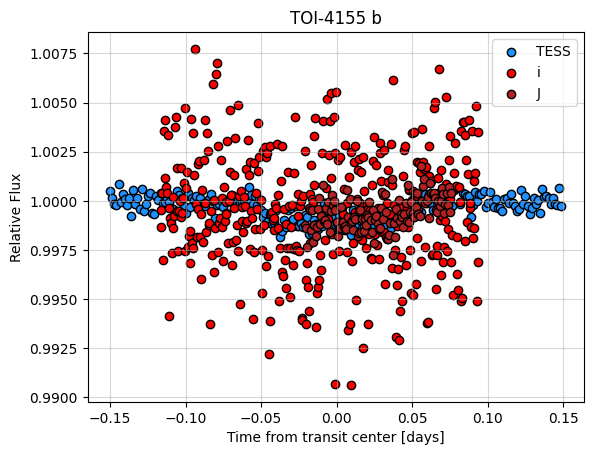

In [13]:
plt.scatter(time, flux, c='dodgerblue', edgecolor='k', label="TESS")
plt.scatter(time_i, flux_i, c='red', edgecolor='k', label="i")
plt.scatter(time_j, flux_j, c='firebrick', edgecolor='k', label="J")
plt.xlabel("Time from transit center [days]")
plt.ylabel("Relative Flux")
plt.title("TOI-4155 b")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

## Removing potential hosts of the TESS signal from the .stars data frame

TESS observes with relatively large pixels (21 arcseconds), which frequently leads to multiple stars appearing within a single target aperture. This contamination means that when a transit signal is detected, the source could be either the target star or a background object within the same aperture.

Depending on both the depth of the observed TESS signal and the relative brightness of nearby stars, background objects may be responsible for apparent transit signals attributed to the target. The `target.calc_depths()` function in TRICERATOPS specifically addresses this issue by identifying all potential host stars for the observed signal.

The code below generates a list of these potential transit source stars:

In [14]:
target.stars[target.stars["tdepth"] > 0]["ID"]

0    467331291
2    467331290
4    467331288
Name: ID, dtype: object

In this case, TRICERATOPS identifies TIC 467331291 (the target), TIC 467331294 (background star), and TIC 467331288 (background star), as potential hosts of the 957ppm signal that TESS detects.

However, we know from the ground-based light curves that the signal of transit must occur around the target, since TIC 467331294 and TIC 467331288 lie outside the apertures of the ground-based light curves. In the next cell of code, we remove these background stars from the .stars dataframe.

In [15]:
# stars that could potentialy host the TESS transit but were ruled out by ground-based followup
filtered_ids = target.stars[target.stars["tdepth"] > 0]["ID"]

filtered_ids_list = filtered_ids.astype(str).tolist()

# Keep only the first ID (target) and remove the rest
ids_to_remove = filtered_ids_list[1:]

# Create numpy array from the list of IDs to remove
filtered_ids_array = np.array(ids_to_remove)

target.remove_star(drop_stars=filtered_ids_array)

In [16]:
# Now we can run TRICERATOPS+

In [17]:
%%time
P_orb = 3.320729
drop_scenario = []
target.calc_probs(time=time, flux_0=flux, flux_err_0=np.mean(flux_err), exptime=tess_texp, P_orb=P_orb, 
                  N = 2000000, contrast_curve_file=contrastcurve_file,  
                  external_lc_files=[j_lightcurve_file, i_lightcurve_file],
                  filt_lcs = ["J", "i"],
                  drop_scenario=drop_scenario, parallel=True) 

griz mags: nan nan nan nan
Calculating TP scenario probability for 467331291.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Calculating EB and EBx2P scenario probabilities for 467331291.
Z, Teff, logg: 0.0 5750 4.5
Calculating PTP scenario probability for 467331291.
Calculating PEB and PEBx2P scenario probabilities for 467331291.
Calculating STP scenario probability for 467331291.
Calculating SEB and SEBx2P scenario probabilities for 467331291.
Calculating DTP scenario probability for 467331291.
Using gmag, rmag, imag, zmag:  11.916179500000002 11.835259999999998 11.436557585487662 11.222880035166295
Calculating DEB and DEBx2P scenario probabilities for 467331291.
Using gmag, rmag, imag, zmag:  11.916179500000002 11.835259999999998 11.436557585487662 11.222880035166295
Calculating BTP scenario probability for 467331291.
Using gmag, rmag, imag, zmag:  11.916179500000002 11.835259999999998 11.436557585487662 11.222880035166295
Calculating BEB and BEBx2P scenario probabilities for 467331291.
Using gmag, rmag, imag, zmag:  11.916179500000002 11.835259999999998 11.436557585487662 11.222880035166295
CPU times: us

In [18]:
# let's print the FPP and NFPP

In [19]:
df_results = target.probs
print("FPP =", np.round(target.FPP, 5))
print("NFPP =", np.round(target.NFPP, 5))
df_results

FPP = 0.00017
NFPP = 0.0


,ID,scenario,M_s,R_s,P_orb,inc,b,ecc,w,R_p,...,R_EB,M_comp,R_comp,flux_ratio_comp_T,prob,lnZ,flux_ratio_EB_J_1,flux_ratio_comp_J_1,flux_ratio_EB_i_2,flux_ratio_comp_i_2
0,467331291,TP,1.164000,0.952646,3.320729,89.458341,0.070234,2.823698e-01,95.256291,3.163039,...,0.000000,0.000000,0.000000,0.000000,8.358062e-01,320.960328,0.000000,0.000000,0.000000,0.000000
1,467331291,EB,1.164000,0.952646,3.320729,81.178590,1.979446,7.774420e-03,290.123148,0.000000,...,0.952646,0.000000,0.000000,0.000000,3.809959e-109,71.495530,0.395601,0.000000,0.373027,0.000000
2,467331291,EBx2P,1.164000,0.952646,6.641458,85.827965,0.917435,7.742432e-01,206.345604,0.000000,...,0.952646,0.000000,0.000000,0.000000,2.416658e-51,204.590233,0.493870,0.000000,0.492655,0.000000
3,467331291,PTP,1.164000,0.952646,3.320729,89.174059,0.143946,3.498257e-02,80.356569,3.832775,...,0.000000,0.983809,0.952646,0.303679,1.389614e-01,319.166128,0.000000,0.337379,0.000000,0.309320
4,467331291,PEB,1.164000,0.952646,3.320729,84.062222,1.125360,1.598603e-02,296.024489,0.000000,...,0.163581,1.162587,0.952646,0.498434,1.734900e-103,84.524372,0.001880,0.498736,0.000361,0.498486
5,467331291,PEBx2P,1.164000,0.952646,6.641458,86.695423,0.491259,8.107007e-01,192.146271,0.000000,...,0.952646,0.418765,0.418863,0.010221,1.962535e-34,243.526031,0.480702,0.027762,0.476815,0.008441
6,467331291,STP,1.152716,0.952646,3.320729,88.267880,0.312168,2.941344e-02,185.109461,4.539817,...,0.000000,1.164000,0.952646,0.487456,1.006378e-04,311.935704,0.000000,0.489870,0.000000,0.487851
7,467331291,SEB,0.543325,0.552254,3.320729,89.393913,0.118382,3.158717e-01,149.203359,0.000000,...,0.100000,1.164000,0.952646,0.021518,3.193359e-39,232.499942,0.000509,0.049091,0.000157,0.019213
8,467331291,SEBx2P,1.043200,0.952646,6.641458,86.833095,0.453825,7.780812e-01,183.383787,0.000000,...,0.952646,1.164000,0.952646,0.365210,2.155973e-38,234.409696,0.366991,0.389872,0.340102,0.366245
9,467331291,DTP,1.164000,0.952646,3.320729,88.891864,0.201300,1.038664e-02,321.756665,3.314135,...,0.000000,0.686000,0.000000,0.072360,2.505796e-02,317.453123,0.000000,0.098241,0.000000,0.060784


In [20]:
# let's visualize the scenarios fits to the TESS data

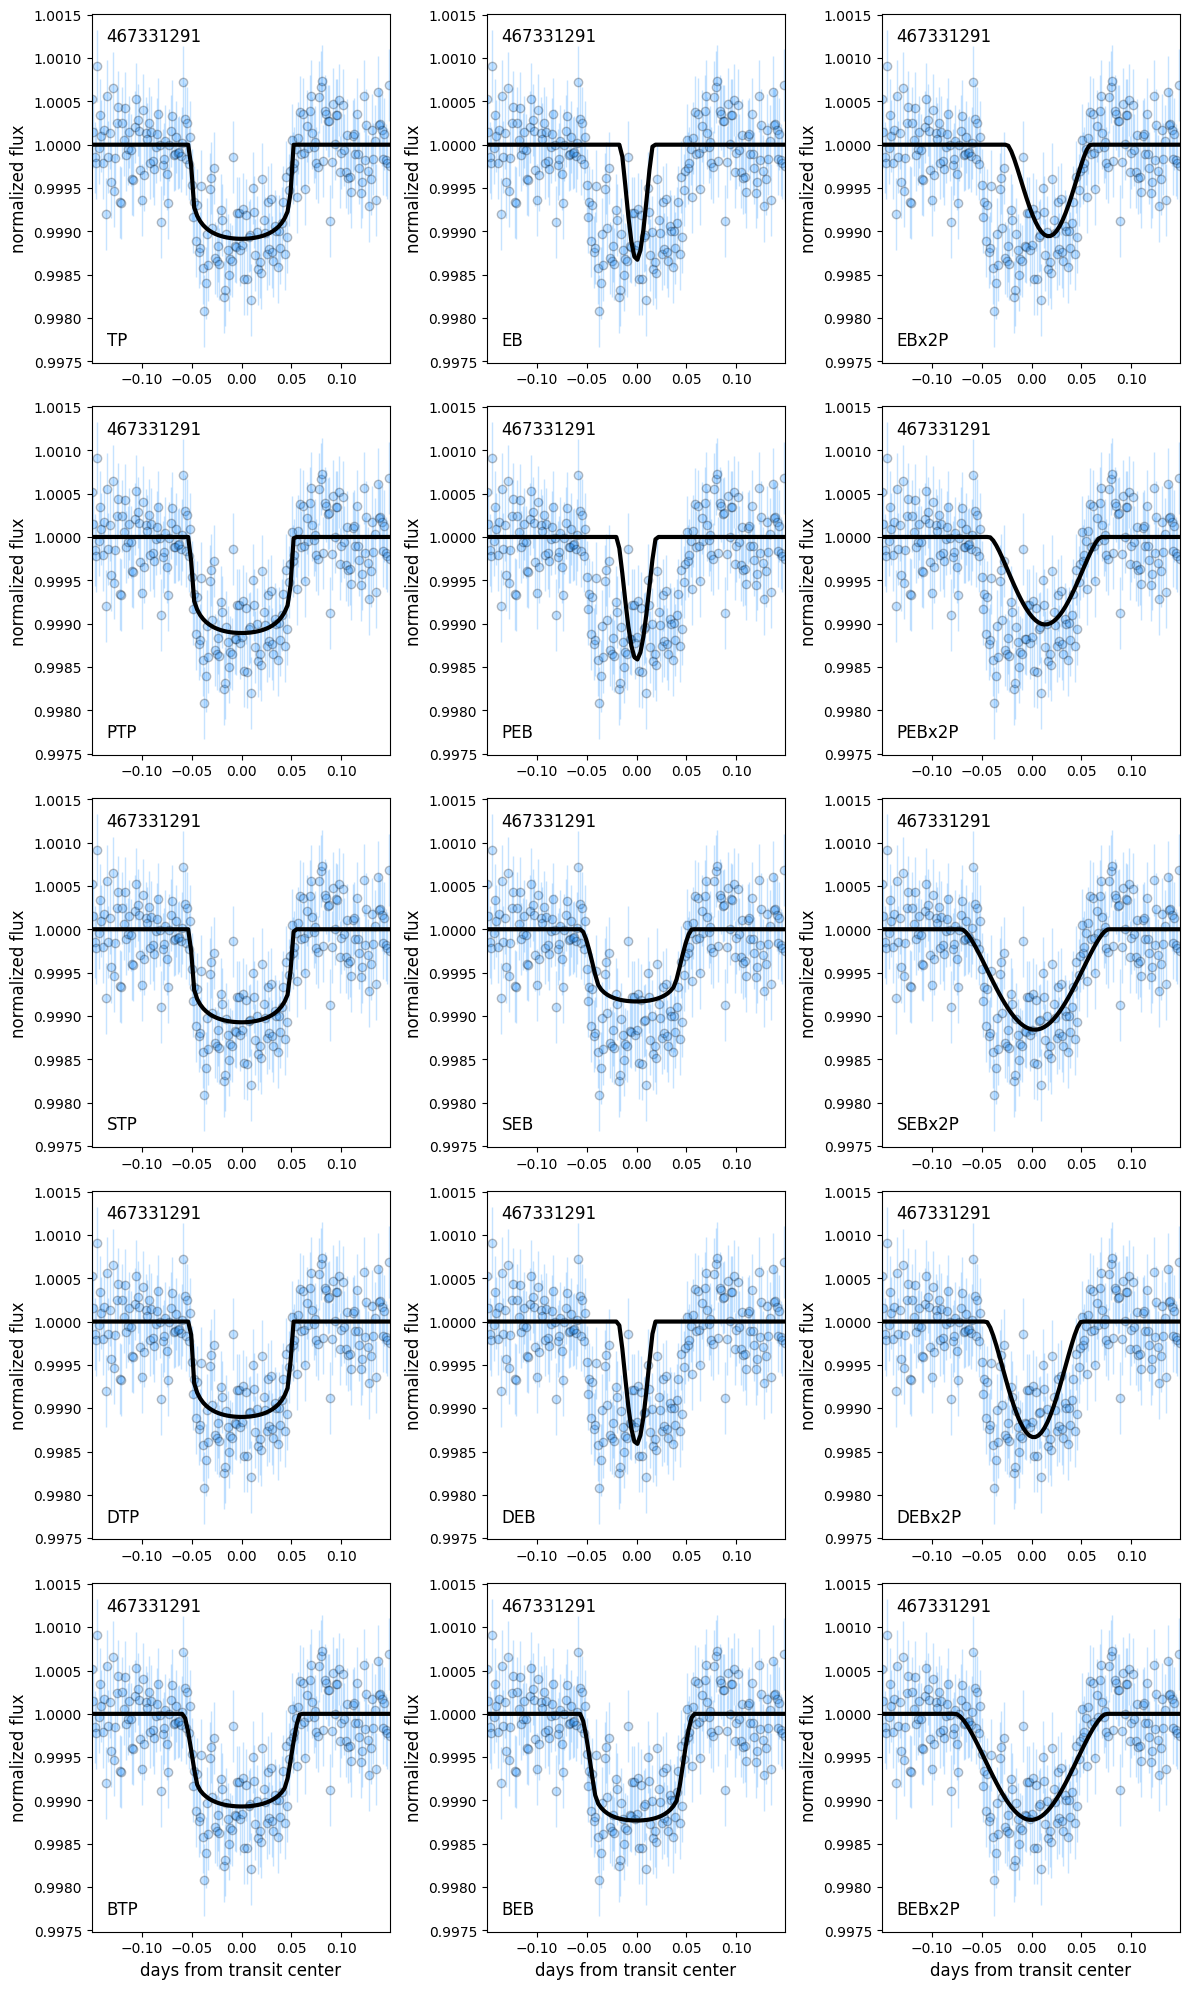

In [21]:
target.plot_fits(time=time, flux_0=flux, flux_err_0=np.mean(flux_err), x_range=[np.min(time), np.max(time)], nrows=0, save=False, fname='TOI-4051_TESS_Data')

# Editing the .stars dataframe to provide SDSS magnitudes

Notice how TRICERATOPS+ prints "Warning: no sdss magnitudes available from TIC. Using empirical relations to estimate g, r, i, z mags." Sometimes the TIC lacks sdss magnitudes, which are needed if we are using ground-based light curves in these filters to compute the false postive probability and the nearby false positive probability. We can get the observed magnitudes in these filters for TIC 467331291 by querying the Pan-STARSS catalog on MAST here https://catalogs.mast.stsci.edu/panstarrs/ and update the .stars dataframe

In [22]:
# from PanSTARSS we get
PanSTARSS_r_mag = 12.434800148010254
PanSTARSS_i_mag = 11.609399795532227
PanSTARSS_z_mag = 11.53499984741211

PanSTARSS lacks a g mag for this star, but we do not have a g mag light curve so this is less important. Let's specify the value that TRICERATOPS originally estimated for the g mag.

In [23]:
TRICERATOPS_plus_g_mag = 11.916179500000002

In [24]:
target.update_star(ID = ID, param="gmag", value = TRICERATOPS_plus_g_mag)
target.update_star(ID = ID, param="rmag", value = PanSTARSS_r_mag)
target.update_star(ID = ID, param="imag", value = PanSTARSS_i_mag)
target.update_star(ID = ID, param="zmag", value = PanSTARSS_z_mag)

In [25]:
# let's verify that we have updated the table
target.stars

,ID,Bmag,Vmag,Tmag,Jmag,Hmag,Kmag,gmag,rmag,imag,...,dec,mass,rad,Teff,d,plx,sep (arcsec),PA (E of N),fluxratio,tdepth
0,467331291,12.147,11.8500,11.2473,10.608,10.309,10.265,11.91618,12.4348,11.6094,...,77.734265,1.164000,0.952646,5724.0,240.737,4.125090,0.000,0.000,9.623704e-01,0.000994
1,2023818168,NaN,21.2127,20.3391,NaN,NaN,NaN,NaN,NaN,NaN,...,77.736817,NaN,NaN,NaN,NaN,NaN,12.671,316.475,2.102069e-04,0.000000
3,2023818169,NaN,20.9308,19.1348,NaN,NaN,NaN,NaN,NaN,NaN,...,77.729445,NaN,NaN,NaN,1079.700,1.005090,17.387,176.336,5.839037e-04,0.000000
5,2023818166,NaN,NaN,20.7020,NaN,NaN,NaN,NaN,NaN,NaN,...,77.736045,NaN,NaN,NaN,NaN,NaN,36.018,79.730,6.803654e-05,0.000000
6,2023818164,NaN,20.5505,19.5404,NaN,NaN,NaN,NaN,NaN,NaN,...,77.726411,NaN,NaN,NaN,2688.800,-0.838810,44.591,230.673,1.142662e-04,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,467331498,19.224,17.4187,15.7877,14.560,13.823,13.633,NaN,NaN,NaN,...,77.742137,0.649962,0.681093,3865.0,630.665,1.558830,200.466,81.746,8.752285e-26,0.000000
134,2023818097,NaN,20.6573,19.4236,NaN,NaN,NaN,NaN,NaN,NaN,...,77.745547,NaN,NaN,NaN,1365.090,0.700979,200.982,78.215,8.119994e-28,0.000000
135,2023818083,NaN,20.7557,18.9368,NaN,NaN,NaN,NaN,NaN,NaN,...,77.708937,NaN,NaN,4022.0,792.683,1.392170,201.258,116.824,3.852072e-27,0.000000
136,2023818235,NaN,19.3607,18.3008,NaN,NaN,NaN,NaN,NaN,NaN,...,77.779055,0.910000,0.534814,5286.0,2225.380,0.314859,201.390,36.730,1.241743e-28,0.000000


Looks good! We can now re-run the code with the updated magnitudes

In [26]:
%%time
P_orb = 3.320729
drop_scenario = []
target.calc_probs(time=time, flux_0=flux, flux_err_0=np.mean(flux_err), exptime=tess_texp, P_orb=P_orb, 
                  N = 2000000, contrast_curve_file=contrastcurve_file,  
                  external_lc_files=[j_lightcurve_file, i_lightcurve_file],
                  filt_lcs = ["J", "i"],
                  drop_scenario=drop_scenario, parallel=True) 

griz mags: 11.916179500000002 12.434800148010254 11.609399795532227 11.53499984741211
Calculating TP scenario probability for 467331291.
Calculating EB and EBx2P scenario probabilities for 467331291.
Z, Teff, logg: 0.0 5750 4.5
Calculating PTP scenario probability for 467331291.
Calculating PEB and PEBx2P scenario probabilities for 467331291.
Calculating STP scenario probability for 467331291.
Calculating SEB and SEBx2P scenario probabilities for 467331291.
Calculating DTP scenario probability for 467331291.
Calculating DEB and DEBx2P scenario probabilities for 467331291.
Calculating BTP scenario probability for 467331291.
Calculating BEB and BEBx2P scenario probabilities for 467331291.
CPU times: user 37min 46s, sys: 55.2 s, total: 38min 42s
Wall time: 6min 41s


In [27]:
df_results = target.probs
print("FPP =", np.round(target.FPP, 5))
print("NFPP =", np.round(target.NFPP, 5))

FPP = 0.0002
NFPP = 0.0
